## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import string
import random

from wordcloud import WordCloud # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns
#! python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
! pip install keras
# Import Tokenizer from tensorflow.keras.preprocessing.text instead of keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler


import gensim # type: ignore
from gensim.models import Word2Vec # type: ignore

## Importing Data

In [ ]:
df = pd.read_csv('Twitter_Data.csv')
df.head(10)




,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace f...,0.0
7,this comes from cabinet which has scholars lik...,0.0
8,with upcoming election india saga going import...,1.0
9,gandhi was gay does modi,1.0


## Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
df.category.value_counts()

,count
category,
1.0,72250
0.0,55213
-1.0,35510


<Axes: xlabel='category', ylabel='count'>

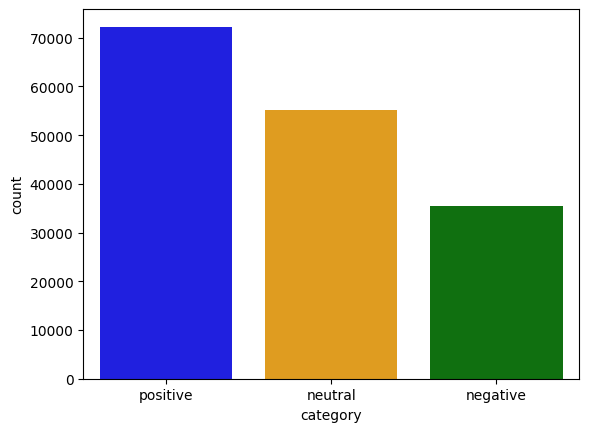

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns

# Data
data = {'category': ['positive', 'neutral', 'negative'], 'count': [72250, 55213, 35510]}
df_category = pd.DataFrame(data)

# Bar plot
sns.barplot(x='category', y='count', data=df_category, palette=['blue', 'orange', 'green'])


In [ ]:
# Count NaN values in the 'clean_text' column
#nan_count_in_A = df['clean_text'].isna().sum()
#print(f"Number of NaN values in 'clean_text': {nan_count_in_A}")


In [ ]:
# Count total NaN values in the entire DataFrame
total_nan_count = df.isna().sum().sum()
print(f"Total number of NaN values in the DataFrame: {total_nan_count}")


Total number of NaN values in the DataFrame: 11


In [ ]:
df.dropna(inplace=True)

In [ ]:
# Count total NaN values in the entire DataFrame
total_nan_count = df.isna().sum().sum()
print(f"Total number of NaN values in the DataFrame: {total_nan_count}")

Total number of NaN values in the DataFrame: 0


From the above we know that there are few empty rows in the dataset.Below is the code to drop the empty rows

#####################################################################<BR>
Below is the process where we clean the tweets by removing the URL, emoji, html tags, punctuation marks and quotes from the 'clean_text'<BR>##########################################################################

In [ ]:
# lets check for length of give tweet text, adding it as feature
def len_(txt):
    txt=txt.split()
    return len(txt)
df['len']=df['clean_text'].apply(len_)

In [ ]:
df.head()

,clean_text,category,len
0,when modi promised “minimum government maximum...,-1.0,33
1,talk all the nonsense and continue all the dra...,0.0,13
2,what did just say vote for modi welcome bjp t...,1.0,22
3,asking his supporters prefix chowkidar their n...,1.0,34
4,answer who among these the most powerful world...,1.0,14


In [ ]:
# Find rows where 'len' is 0
rows_with_len_zero = df[df['len'] == 0]

# Print the rows
print("Rows where 'len' is 0:")
print(rows_with_len_zero)

# Store rows in an array
rows_array = rows_with_len_zero.to_numpy()

# Print the array
print("Rows stored in array:")
print(rows_array)


Rows where 'len' is 0:
      clean_text  category  len
77224                  0.0    0
Rows stored in array:
[[' ' 0.0 0]]


In [ ]:
df = df.drop(index=77224)

In [ ]:
max_length_clean_text = df['len'].max()
print("tweet max_length =", max_length_clean_text)
min_length_clean_text = df['len'].min()
print("tweet min_length =", min_length_clean_text)
mean_length_clean_text = df['len'].mean()
print("tweet mean_length =", mean_length_clean_text)

tweet max_length = 52
tweet min_length = 1
tweet mean_length = 20.08082568356978


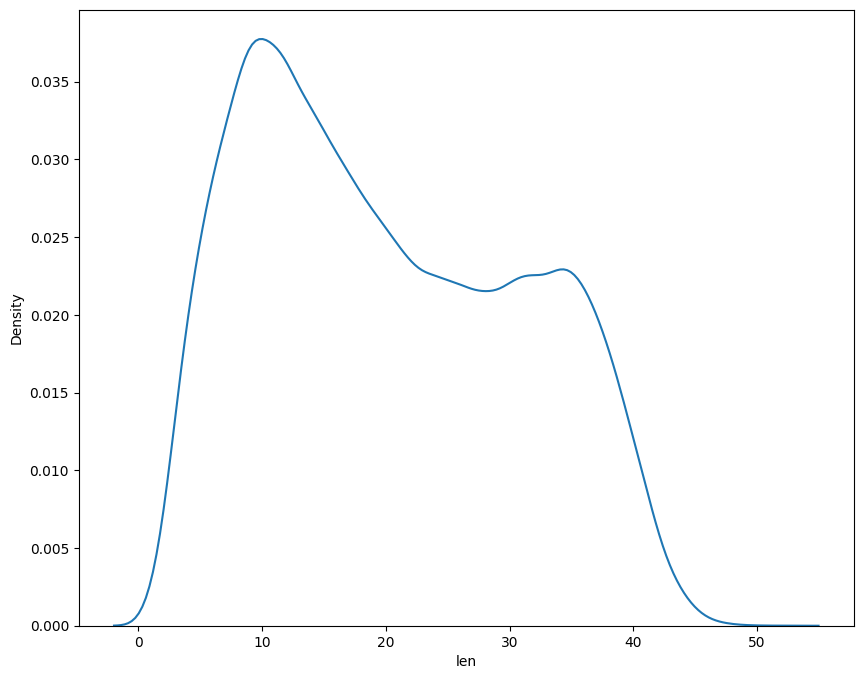

In [ ]:
plt.figure(figsize=(10,8))
sns.kdeplot(df['len'])
plt.savefig('pdf.png')
plt.show()

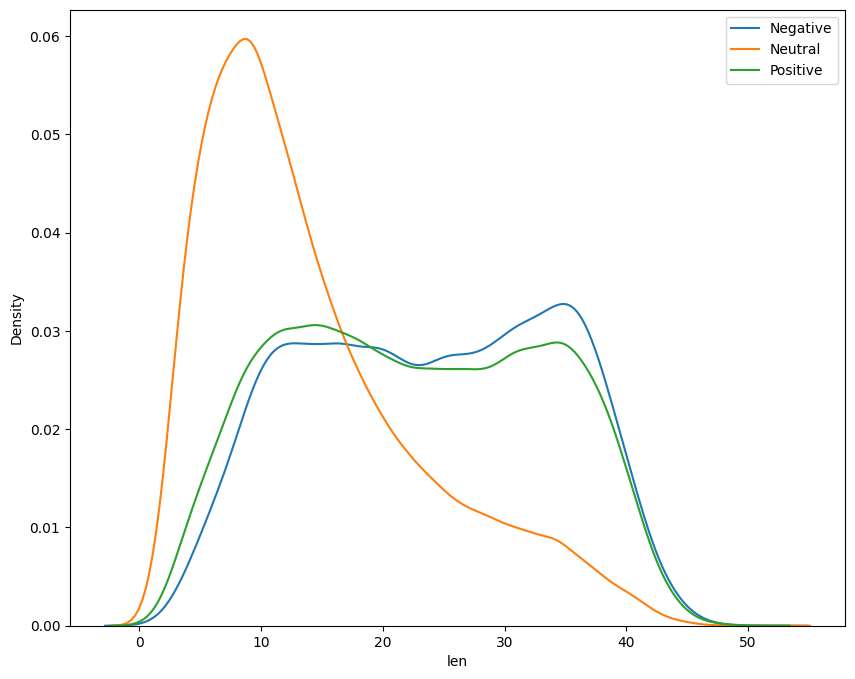

In [ ]:
# Now we will illustrate the KDE plot as per the category. i.e. length of tweet category-wise
plt.figure(figsize=(10,8))
sns.kdeplot(df.loc[df.category==-1].len)
sns.kdeplot(df.loc[df.category==0].len)
sns.kdeplot(df.loc[df.category==1].len)
plt.legend(['Negative','Neutral','Positive'])
plt.savefig('pdf.png')
plt.show()

**Observations:** <br>
We see from the above plot that both positive and negative tweets can vary in length from using minimum to maximum words at almost same frequency.
We see that most of the neutral tweets are between 1-20 words and only few are longer.

###################################################################################################<br>
We will now remove URL,emoji, html tags, punctuation and quotes from the clean_text <br>
##################################################################################################<br>

In [ ]:
print(df['clean_text'][19]),
print(df['clean_text'][91]),
print(df['clean_text'][52])

didn’ write chowkidar does mean ’ anti modi try visit the plz not all who haven’ used are anti 
dont forget petrol prices have risen ₹ modi government when gulf prices were going down ाेशबचा 
farmers’ welfare about 474 farmers get second installment from next month the centre announced the 75000crore scheme 


In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)




In [ ]:
# Applying helper functions
df1 = df.copy()
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_URL(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_emoji(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_html(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_punct(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_quotes(x))
df1['clean_text'] = df1['clean_text'].str.lower()


print(df1['clean_text'][19]),
print(df1['clean_text'][91]),
print(df1['clean_text'][52]),

didn write chowkidar does mean  anti modi try visit the plz not all who haven used are anti 
dont forget petrol prices have risen  modi government when gulf prices were going down  
farmers welfare about 474 farmers get second installment from next month the centre announced the 75000crore scheme 


(None,)

# Exploratary Data Analysis

**Inference**

Positive data is the larger than negative.

Which means our data is not balanced. We'll keep that in my mind when we'll train and test our data.

**Inference**

> Most tweets prefer to use less than 40 words to write a tweet.
>
> Generally, tweeters write about 10 - 37 words













**Inference**


> The twitter has a limitation of 280 words and yet tweeters use anywhere between 50-200 characters
>





In [ ]:
from wordcloud import WordCloud, STOPWORDS
def get_cloud(data):
    comment_words = ''
    for val in data:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        tok=[]
        for i in tokens:
            if i not in STOPWORDS:
                tok.append(i)

        comment_words += " ".join(tok)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(comment_words)
    return wordcloud
def plot_cloud(x,t):
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(x)
    plt.title('X')
    plt.axis("off")
    plt.title(t)
    #plt.tight_layout(pad = 0)

    plt.show()

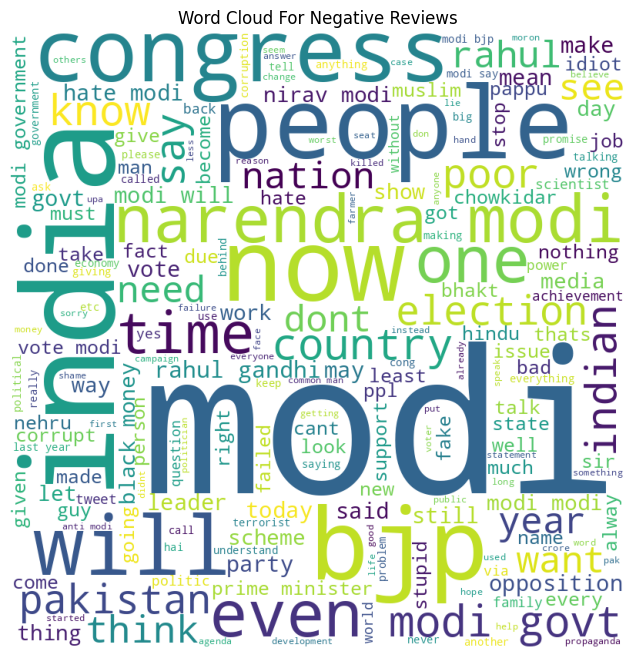

In [ ]:
wc=get_cloud(df1.loc[df1.category==-1].clean_text.values)
plot_cloud(wc,'Word Cloud For Negative Reviews')

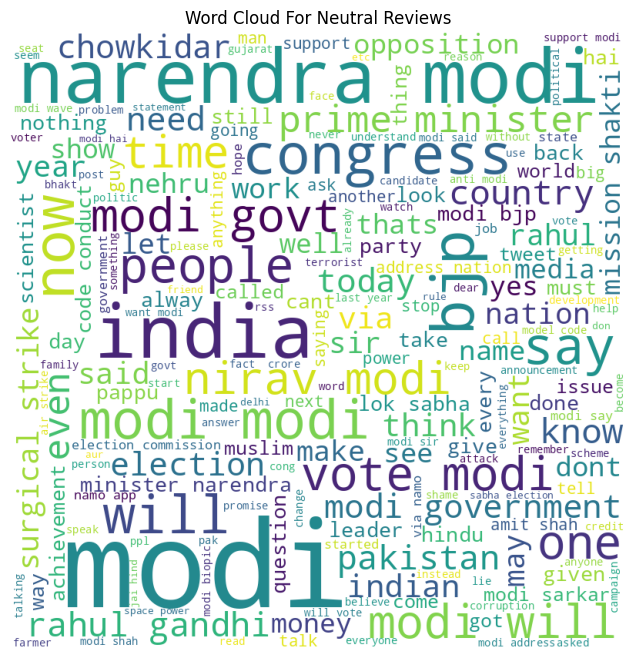

In [ ]:
wc=get_cloud(df.loc[df.category==0].clean_text.values)
plot_cloud(wc,'Word Cloud For Neutral Reviews')

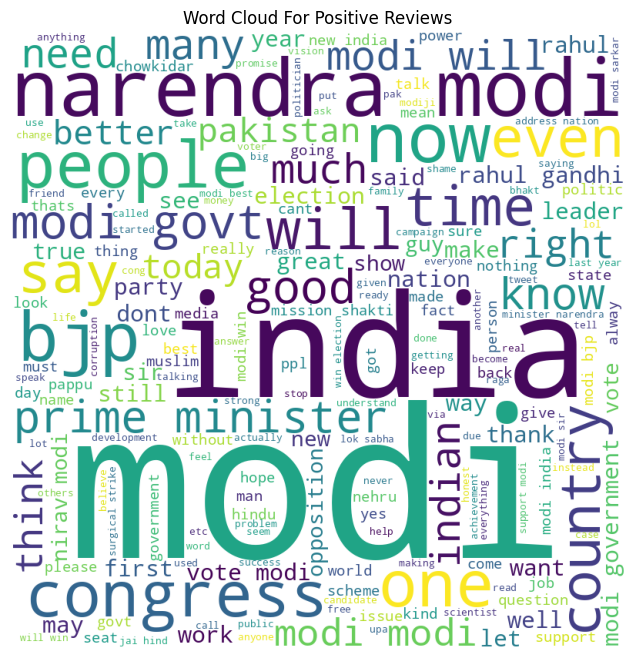

In [ ]:
wc=get_cloud(df.loc[df.category==1].clean_text.values)
plot_cloud(wc,'Word Cloud For Positive Reviews')

Inference

> One thing is clear that our data comes largely from India as evident from WordCloud
>
> The topic also seems to be around politics primarily talking about 'bjp', 'congress' and 'modi'
>
> The word 'modi', prime minister of India, is used in every sentiment indicating both support and opposition for "Modi Government".

**CLASSIFICATION**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
import pickle
from sklearn.utils import resample,shuffle
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
!pip install keras-tcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from tcn import TCN

In [ ]:
#!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing import text
#from tensorflow.keras.layers.experimental.preprocessing import RandomFourierFeatures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd


# Separate features (X) and target (y)
X = df1['clean_text']  # Replace with the feature columns
y = df1['category']    # Target column

# Encode text data if necessary (e.g., using TF-IDF or similar methods for text data)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_vectorized, y)

# Decode the balanced features back to text (if needed)
X_balanced_text = vectorizer.inverse_transform(X_balanced)

# Combine balanced features and target into a DataFrame
balanced_df = pd.DataFrame({
    'clean_text': [' '.join(text) for text in X_balanced_text],
    'category': y_balanced
})

# Save to CSV
balanced_df.to_csv('tweet_balanced.csv', index=False)

print("Balanced dataset saved to 'tweet_balanced.csv'")


Balanced dataset saved to 'tweet_balanced.csv'


In [ ]:
# Check category-wise counts
category_counts = balanced_df['category'].value_counts()

# Print the counts
print("Category-wise counts in the balanced dataset:")
print(category_counts)


Category-wise counts in the balanced dataset:
category
-1.0    72249
 0.0    72249
 1.0    72249
Name: count, dtype: int64


#########################################################################

In [ ]:
import pandas as pd

# Load the balanced dataset

In [ ]:
bal_df = pd.read_csv('tweet_balanced.csv')

In [ ]:
# Check category-wise counts
category_counts = bal_df['category'].value_counts()

# Print the counts
print("Category-wise counts in the balanced dataset:")
print(category_counts)

Category-wise counts in the balanced dataset:
category
-1.0    72249
 0.0    72249
 1.0    72249
Name: count, dtype: int64


In [ ]:
# Remove rows with NaN values in bal_df
bal_df = bal_df.dropna()

# Verify if there are no more NaN values
print(bal_df.isna().sum())


clean_text    0
category      0
dtype: int64


In [ ]:
# Check category-wise counts
category_counts = bal_df['category'].value_counts()

# Print the counts
print("Category-wise counts in the balanced snd no NAN dataset:")
print(category_counts)


Category-wise counts in the balanced snd no NAN dataset:
category
 1.0    72249
 0.0    71902
-1.0    71423
Name: count, dtype: int64


1.0    72249 <br>
 0.0    71902 <br>
-1.0    71423 <br>

# Baseline Model

In [ ]:
X = bal_df['clean_text']
Y = bal_df['category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify = Y,
                                                    random_state = 34)

In [ ]:
#Initialize the tf-id vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

#Using the vectorizer to fit on out training data and testing data
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)

In [ ]:
# Create a Majority Class Classifier
majority_classifier = DummyClassifier(strategy="most_frequent")
majority_classifier.fit(tfidf_train, y_train)

# Predict the majority class for all instances in the test set
y_pred_majority = majority_classifier.predict(tfidf_test)

In [ ]:
# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_majority))


Classification Report:

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00     14285
         0.0       0.00      0.00      0.00     14380
         1.0       0.34      1.00      0.50     14450

    accuracy                           0.34     43115
   macro avg       0.11      0.33      0.17     43115
weighted avg       0.11      0.34      0.17     43115



# Traditional Machine Learning Model

## Naive Bayes

In [ ]:
#bal_df = pd.read_csv('tweet_balanced.csv')

In [ ]:
#Initialize the Multinomial Naive Bayes classifier
best_accuracy = 0
a = 0.1
while a <= 1:
  nb = MultinomialNB(alpha=a)

  #Fitting the model
  nb.fit(tfidf_train, y_train)
  curr_accuracy = nb.score(tfidf_test, y_test)
  print(f"Accuracy with alpha {a}: {curr_accuracy}")
  # Predict the labels
  if curr_accuracy > best_accuracy:
    best_accuracy = curr_accuracy
    y_pred = nb.predict(tfidf_test)
  a = a + 0.05

Accuracy with alpha 0.1: 0.7428505160616955
Accuracy with alpha 0.15000000000000002: 0.7462136147512467
Accuracy with alpha 0.2: 0.7488808999188218
Accuracy with alpha 0.25: 0.7493911631682709
Accuracy with alpha 0.3: 0.7504116896671692
Accuracy with alpha 0.35: 0.7508987591325524
Accuracy with alpha 0.39999999999999997: 0.7510611156210135
Accuracy with alpha 0.44999999999999996: 0.7511075031891453
Accuracy with alpha 0.49999999999999994: 0.7505276585874986
Accuracy with alpha 0.5499999999999999: 0.7495767134407979
Accuracy with alpha 0.6: 0.7484402180215702
Accuracy with alpha 0.65: 0.7473269163864085
Accuracy with alpha 0.7000000000000001: 0.7464223588078395
Accuracy with alpha 0.7500000000000001: 0.7453786385248753
Accuracy with alpha 0.8000000000000002: 0.7445668560825699
Accuracy with alpha 0.8500000000000002: 0.7434767482314739
Accuracy with alpha 0.9000000000000002: 0.7421315087556535
Accuracy with alpha 0.9500000000000003: 0.7410182071204917


### Evaluate Performance

In [ ]:
# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

        -1.0       0.73      0.74      0.73     14285
         0.0       0.85      0.62      0.71     14380
         1.0       0.71      0.90      0.79     14450

    accuracy                           0.75     43115
   macro avg       0.76      0.75      0.75     43115
weighted avg       0.76      0.75      0.75     43115



**Inference:**

Based on the evaluation metrics, the text classification model demonstrates a GOOD overall performance. It achieves an accuracy of almost 75%, with somewhat imbalanced precision and precise recall for both classes. The F1-score further support this conclusion.

### Prediction using Naive Bayes

## Logistic Regression

In [ ]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(tfidf_train, y_train)

logistic_prediction = logistic_regression.predict(tfidf_test)
logistic_accuracy = accuracy_score(y_test, logistic_prediction)
print(f"Accuracy: {logistic_accuracy}")

Accuracy: 0.8688391511075032


### Evaluate Performance

In [ ]:
# Print the Classification Report
cr = classification_report(y_test, logistic_prediction)
print("\n\nClassification Report\n")
print(cr)



Classification Report

              precision    recall  f1-score   support

        -1.0       0.85      0.78      0.82     14285
         0.0       0.83      0.90      0.86     14380
         1.0       0.92      0.92      0.92     14450

    accuracy                           0.87     43115
   macro avg       0.87      0.87      0.87     43115
weighted avg       0.87      0.87      0.87     43115



**Inference:**

These metrics suggest that the text classification model demonstrates great overall performance with an accuracy of 86% in classifying text data. It can effectively identify positive and negative tweets with a balanced accuracy and has a good ability to differentiate between the classes.

In [ ]:
from sklearn.model_selection import train_test_split # Import the train_test_split function
train,test=train_test_split(bal_df,stratify=bal_df.category.values,test_size=0.2)

In [ ]:
y_train=train.category.values
y_test=test.category.values

In [ ]:
# function to plot confusion matrix and precision and recall matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))

    labels = ['Negative', 'Neutral', 'Positive']
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

Since we have cleaned the text data, we will now create vectors of text using different approaches

## **Bag of Words**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Replace NaN values in 'clean_text' with empty strings in both train and bal_df
train['clean_text'] = train['clean_text'].fillna('')
bal_df['clean_text'] = bal_df['clean_text'].fillna('')

# Convert count vectorizer to a NumPy array
data = train['clean_text'].values

# Change stop_words to 'english' instead of a set
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df=300)
cv = vectorizer.fit(data)

# Transform the text data into numerical features using the fitted CountVectorizer
X = cv.transform(bal_df['clean_text'].values).toarray()

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,                                 # Feature matrix (word embeddings)
    bal_df.category.values,            # Target labels
    test_size=0.2,                     # Proportion of the dataset to include in the test split (e.g., 20%)
    random_state=42,                   # For reproducibility
    stratify=bal_df.category.values    # Ensures train/test split has the same label distribution (optional)
)

# Output shapes for verification
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (172459, 1082)
Shape of X_test: (43115, 1082)
Shape of y_train: (172459,)
Shape of y_test: (43115,)


In [ ]:
lgbm=lgb.LGBMClassifier(boosting_type='gbdt', class_weight= 'balanced',
                                                colsample_bytree=1.0, importance_type='gain',
                                                learning_rate=0.5, max_depth=-1, metric='None',
                                                min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
                                                n_estimators=200, n_jobs=-1, num_leaves=46, objective=None,
                                                random_state= 403, reg_alpha=0, reg_lambda=0, silent=False,
                                                subsample= 0.90, subsample_for_bin=15000,
                                                subsample_freq=0)
lgbm.fit(X_train,y_train)
pred=lgbm.predict(X_test)
print('Accuracy =',accuracy_score(y_test,pred))
print('F1 score =',f1_score(y_test,pred,average='macro'))

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.903570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 172459, number of used features: 1081
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Unknown parameter: silent
Accuracy = 0.7245738142177897
F1 score = 0.726167765827615


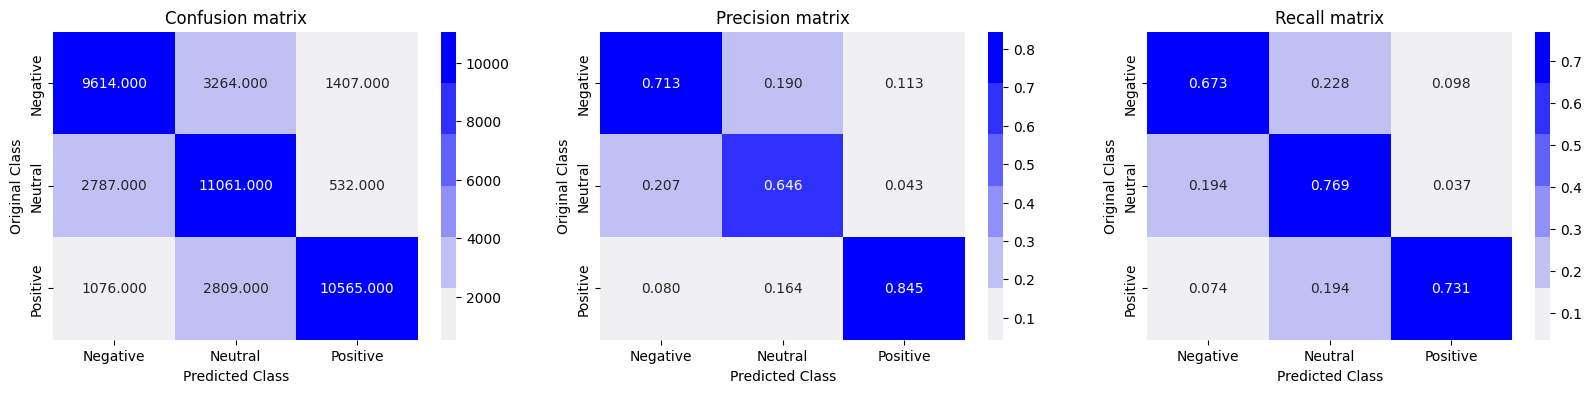

In [ ]:

plot_confusion_matrix(y_test,pred)

**Conclusion** <br>
The Light Gradient boosting model which used Bag of Words (BOW) vectorization strategy gives Accuracy and F1 score of @73% <br>
The model performs well on positive instances (high precision of 0.847), but struggles with neutral instances (low precision of 0.200). It has moderate recall for negative (0.671) and positive (0.729) classes, and a high recall for neutral (0.775).<br>
To improve this model, we need to focus on reducing false positives for neutral and increasing recall for negative.

# **Word2Vec**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import numpy as np

def load_glove_model(glove_file):
    """Loads GloVe embeddings from a text file.

    Args:
        glove_file (str): Path to the GloVe embeddings file.

    Returns:
        dict: A dictionary mapping words to their GloVe embeddings.
    """
    print("Loading Glove Model")
    model = {}
    with open(glove_file,'r') as f:
        for line_number, line in enumerate(f, 1):  # Track line numbers for debugging
            try:
                splitLine = line.strip().split()  # Strip whitespace and split
                word = splitLine[0]
                embedding = np.array([float(val) for val in splitLine[1:]])
                model[word] = embedding
            except ValueError as e:
                print(f"Error on line {line_number}: {e}")
                print(f"Problematic line: {line.strip()}")  # Print the problematic line for inspection
                # You can choose to skip this line or handle the error in a different way
                # For now, we'll just print the error and continue
    print("Done.",len(model)," words loaded!")
    return model

# Replace the pickle loading with the custom function
# Pass the file path directly to the function
model = load_glove_model('glove_twitter_27B_200d.txt')
glove_words = set(model.keys())

Loading Glove Model
Done. 1152746  words loaded!


In [ ]:
!pip install tqdm  # Install the tqdm library if you haven't already
from tqdm import tqdm  # Import the tqdm function

avg_w2v_vectors = [];
for sentence in tqdm(bal_df.clean_text.values): # for each sentence
    vector = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 215574/215574 [00:04<00:00, 44592.87it/s]

215574
200


In [ ]:
from sklearn.model_selection import train_test_split
# Convert avg_w2v_vectors to a NumPy array
X = np.array(avg_w2v_vectors)
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,                                 # Feature matrix (word embeddings)
    bal_df.category.values,            # Target labels
    test_size=0.2,                     # Proportion of the dataset to include in the test split (e.g., 20%)
    random_state=42,                   # For reproducibility
    stratify=bal_df.category.values    # Ensures train/test split has the same label distribution (optional)
)

# Output shapes for verification
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (172459, 200)
Shape of X_test: (43115, 200)
Shape of y_train: (172459,)
Shape of y_test: (43115,)


In [ ]:
lgb.LGBMClassifier(boosting_type='gbdt', class_weight= 'balanced',
                                                colsample_bytree=1.0, importance_type='gain',
                                                learning_rate=0.5, max_depth=-1, metric='None',
                                                min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
                                                n_estimators=200, n_jobs=-1, num_leaves=46, objective=None,
                                                random_state= 403, reg_alpha=0, reg_lambda=0, silent=False,
                                                subsample= 0.90, subsample_for_bin=15000,
                                                subsample_freq=0)
lgbm.fit(X_train,y_train)
pred=lgbm.predict(X_test)
print('Accuracy =',accuracy_score(y_test,pred))
print('F1 score =',f1_score(y_test,pred,average='macro'))

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.289408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 172459, number of used features: 200
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Unknown parameter: silent
Accuracy = 0.7006378290618114
F1 score = 0.6999967143597807


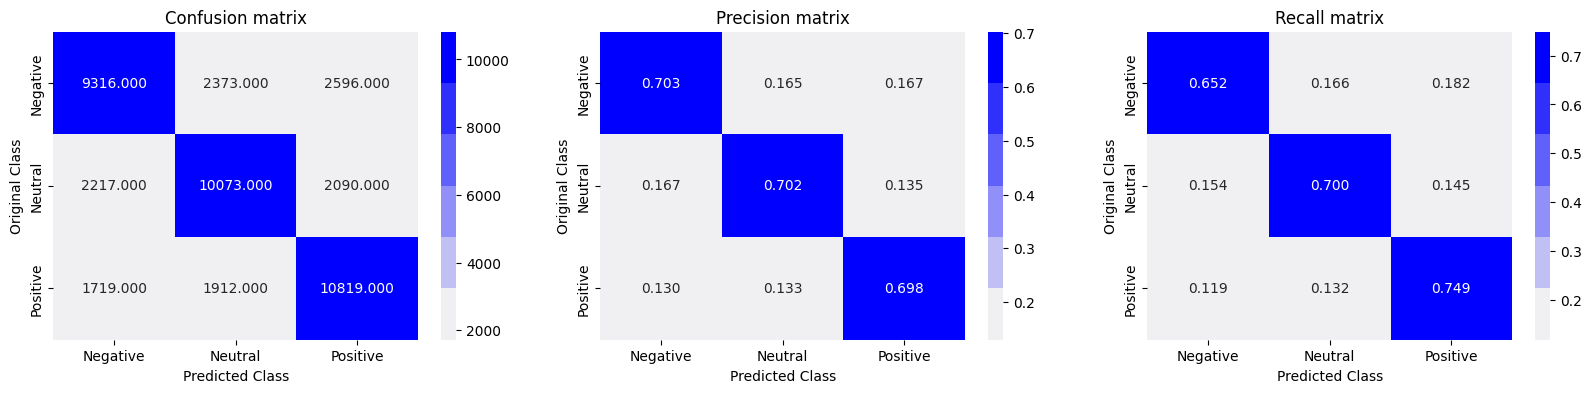

In [ ]:
plot_confusion_matrix(y_test,pred)

# Conclusion

Confusion Matrix: The Positive class has the highest true positives (11,144) with fewer false positives. The Neutral class performs moderately well (10,053 true positives) but shows notable misclassifications. The Negative class has decent predictions but higher misclassification rates.<br>
Precision Matrix: The Positive class has the highest precision (0.686), followed by the Negative class (0.718). The Neutral class has the lowest precision (0.170), indicating struggles with false positives.<br>
Recall Matrix: The Positive class has the highest recall (0.771), followed by Neutral (0.699) and Negative (0.621), indicating the model is most effective at identifying Positive samples.<br>
Overall, the model performs best in predicting the Positive class, with high precision (0.686) and recall (
0.771). The Neutral class shows moderate recall (0.699) but struggles with precision (0.170), leading to frequent misclassifications. The Negative class performs reasonably well, with good precision (0.718) but lower recall (0.621). Overall, the model is most effective at identifying Positive samples and faces challenges in accurately predicting the Neutral class.

**Compared to BOW model** <br>
The current model (Word2Vec) outperforms the BOW model in identifying Positive and Negative samples, with much higher precision and recall. However, it struggles significantly with the Neutral class, showing poor precision compared to the BOW model. This suggests the current model may be better suited for tasks prioritizing Positive and Negative predictions.









# TF-IDF Weighted Word2Vec

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()
tfidf_model.fit(bal_df.clean_text.values)

# Use get_feature_names_out() instead of get_feature_names()
dictionary = dict(zip(tfidf_model.get_feature_names_out(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names_out()) # Use get_feature_names_out() here as well

In [ ]:
tfidf_w2v_vectors = []
for sentence in tqdm(bal_df.clean_text.values):
    vector = np.zeros(200)
    tf_idf_weight =0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 215574/215574 [00:18<00:00, 11538.24it/s]

215574
200


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# Convert avg_w2v_vectors to a NumPy array
X = np.array(tfidf_w2v_vectors)
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,                                 # Feature matrix (word embeddings)
    bal_df.category.values,            # Target labels
    test_size=0.2,                     # Proportion of the dataset to include in the test split (e.g., 20%)
    random_state=42,                   # For reproducibility
    stratify=bal_df.category.values    # Ensures train/test split has the same label distribution (optional)
)

# Output shapes for verification
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (172459, 200)
Shape of X_test: (43115, 200)
Shape of y_train: (172459,)
Shape of y_test: (43115,)


In [ ]:
lgb.LGBMClassifier(boosting_type='gbdt', class_weight= 'balanced',
                                                colsample_bytree=1.0, importance_type='gain',
                                                learning_rate=0.5, max_depth=-1, metric='None',
                                                min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
                                                n_estimators=200, n_jobs=-1, num_leaves=46, objective=None,
                                                random_state= 403, reg_alpha=0, reg_lambda=0, silent=False,
                                                subsample= 0.90, subsample_for_bin=15000,
                                                subsample_freq=0)
lgbm.fit(X_train,y_train)
pred=lgbm.predict(X_test)
accuracy_score(y_test,pred)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 172459, number of used features: 200
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Unknown parameter: silent


0.6913603154354633

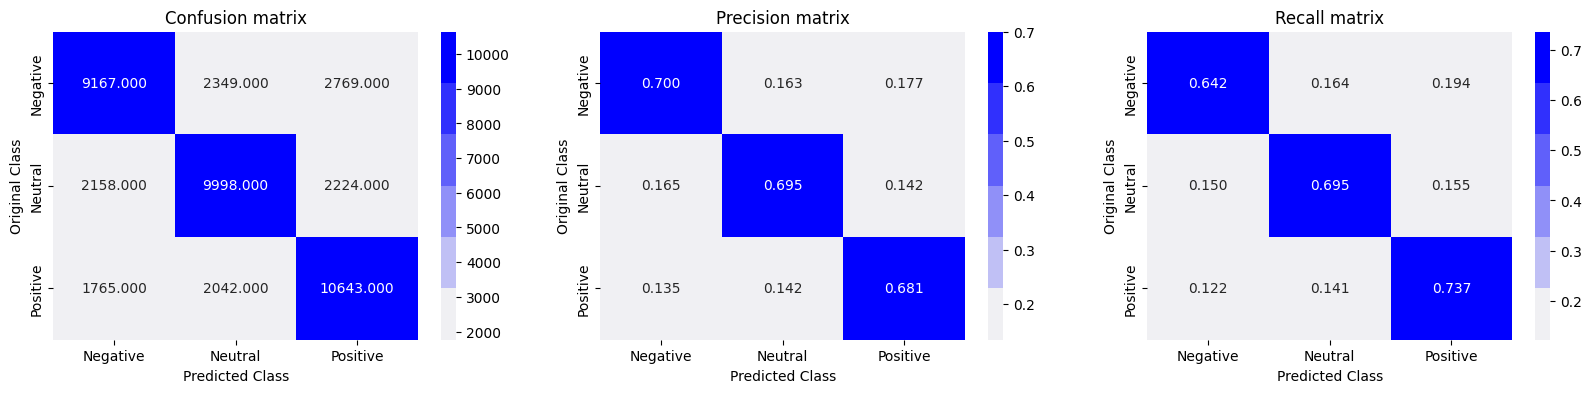

In [ ]:
plot_confusion_matrix(y_test,pred)

# Conclusion

The model struggles to accurately classify positive and neutral instances, often misclassifying them as negative. It performs better for the negative class but is likely biased. To improve accuracy, we have already addressed class imbalance by oversampling technique.We can use different algorithms and techniques to see if those techniques caputre the syntactic and semantic information better<br>
**Comparision of (TFIDF + W2Vec)model with W2Vec model**<br>
The combination of TF-IDF and W2Vec seems to have improved the overall performance of the model, especially for the positive and neutral classes. This suggests that incorporating TF-IDF features helps capture important semantic and syntactic information, leading to better classification accuracy.


# BERT

We are gonna use pre trained bert model to get sentence vectors and then use it to train our model

In [4]:
!pip install bert-tensorflow # Install the bert-tensorflow package which includes the tokenization module

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from bert import tokenization # Import tokenization from bert

In [6]:
!pip install sentencepiece


In [7]:
import pandas as pd
bal_df = pd.read_csv('tweet_balanced.csv')
# Check category-wise counts
category_counts = bal_df['category'].value_counts()

# Print the counts
print("Category-wise counts in the balanced dataset:")
print(category_counts)

Category-wise counts in the balanced dataset:
category
-1.0    72249
 0.0    72249
 1.0    72249
Name: count, dtype: int64


In [8]:
# Remove rows with NaN values in bal_df
bal_df = bal_df.dropna()

# Verify if there are no more NaN values
print(bal_df.isna().sum())

clean_text    0
category      0
dtype: int64


In [9]:
# Check category-wise counts
category_counts = bal_df['category'].value_counts()

# Print the counts
print("Category-wise counts in the balanced snd no NAN dataset:")
print(category_counts)

Category-wise counts in the balanced snd no NAN dataset:
category
 1.0    72249
 0.0    71902
-1.0    71423
Name: count, dtype: int64


In [10]:
def length(text):
    text=text.split()
    return len(text)
bal_df['len']=bal_df['clean_text'].apply(length)

In [11]:
bal_df.head()


,clean_text,category,len
0,when modi promised minimum government maximum ...,-1.0,28
1,modi the and talk all nonsense continue drama ...,0.0,11
2,modi the should vote for what did just say wel...,1.0,18
3,modi not will what did asking his supporters p...,1.0,31
4,modi the most answer who among these powerful ...,1.0,14


In [12]:

min(bal_df.len.values),max(bal_df.len.values)

(1, 45)

In [13]:
!pip install tensorflow tensorflow-hub tensorflow-text

In [14]:
!pip install bert-tensorflow==1.0.1

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import bert
from bert import tokenization
import numpy as np

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Parameters
max_seq_length = 50  # Maximum sequence length for input tokens
# Force TensorFlow to use the GPU
with tf.device('/GPU:0'):  # Or '/GPU:1' if you have multiple GPUs
    # Load the BERT preprocessing model and encoder
    preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
    bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=False, name="BERT_Encoder")


# Define inputs
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")  # Input as raw text

# Wrap the preprocessing and BERT layers in a tf.function
@tf.function
def preprocess_and_encode(inputs):
    """Preprocesses and encodes the input text using BERT."""
    preprocessed_inputs = preprocess_model(inputs)
    # Disable gradient calculation within this function for the BERT layer
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(preprocessed_inputs)  # Only watch the preprocessed inputs
        bert_outputs = bert_model(preprocessed_inputs, training=False)  # Explicitly set training=False
    return bert_outputs["pooled_output"]


# Apply the function to the input tensor
pooled_output = tf.keras.layers.Lambda(preprocess_and_encode, output_shape=(768,))(text_input)
# Add classification layers
x = tf.keras.layers.Dropout(0.1)(pooled_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(3, activation='softmax', name="classifier")(x)  # Assuming 3 sentiment classes

# Build and compile the model
model = tf.keras.Model(inputs=text_input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)                    │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (Dense)                   │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,635 (772.01 KB)

 Trainable params: 197,635 (772.01 KB)

 Non-trainable params: 0 (0.00 B)

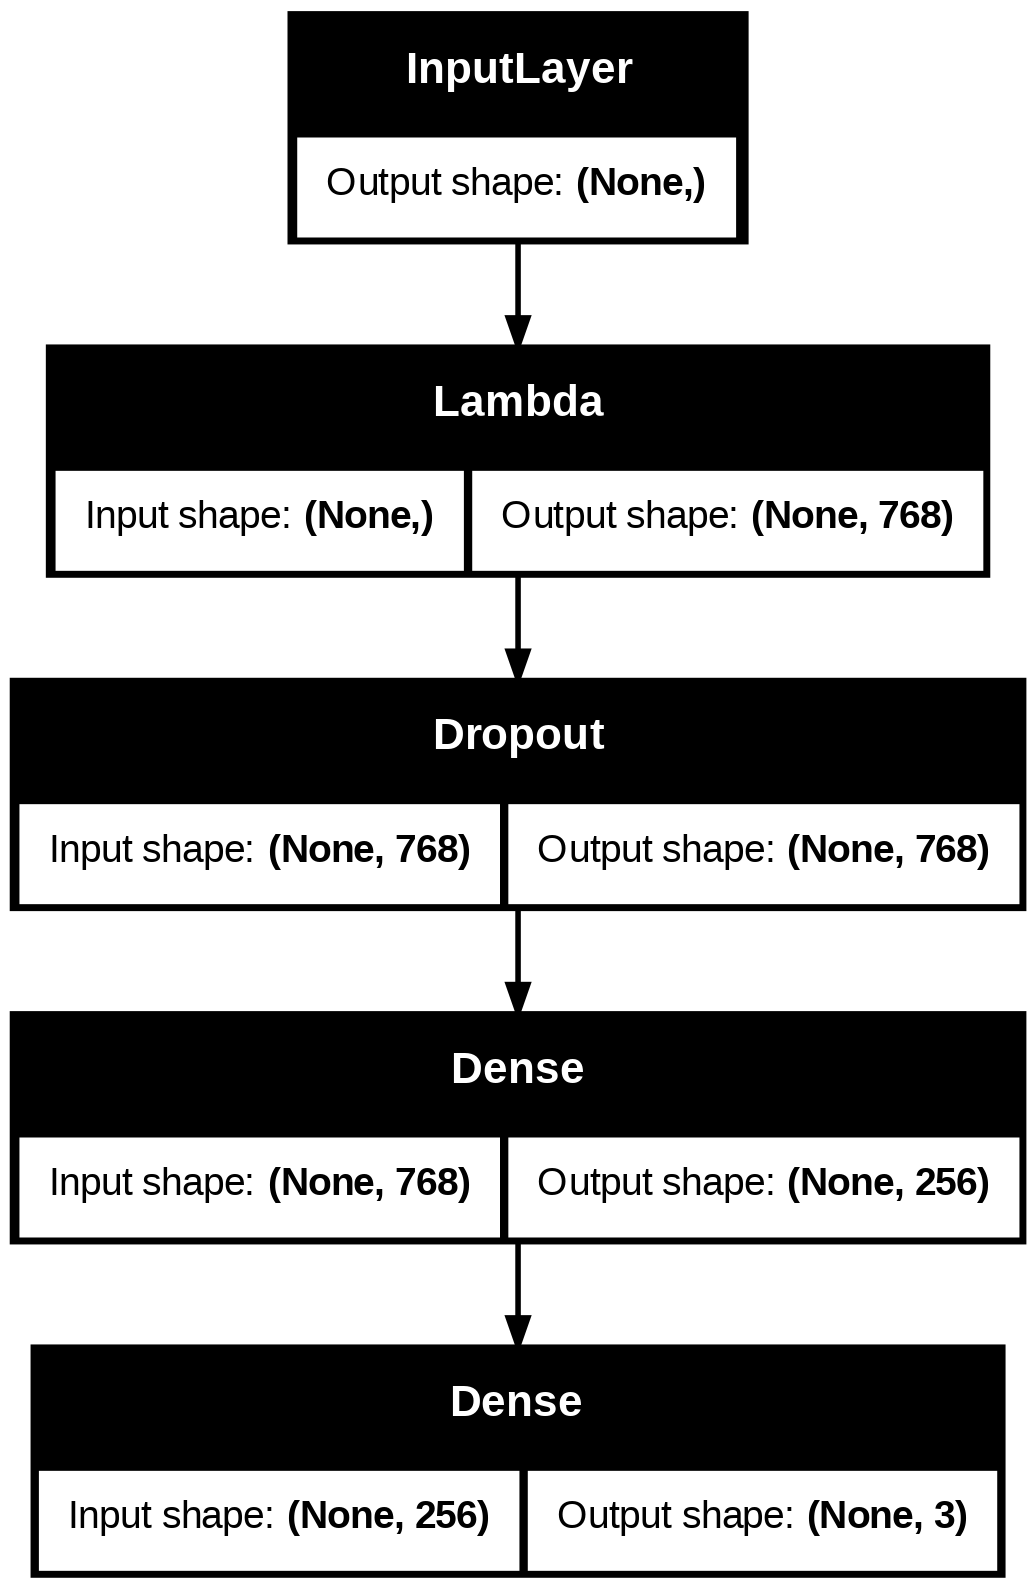

In [16]:
tf.keras.utils.plot_model(model, "text_clss.png", show_shapes=True)

In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Parameters
BERT_PREPROCESS_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
BERT_MODEL_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

def fit_model(model, texts, labels, batch_size=32, epochs=3, validation_split=0.2):
    """
    Fits the BERT-based sentiment model.

    Args:
        model: The compiled Keras model.
        texts: List or array of raw text inputs.
        labels: List or array of categorical labels (e.g., [0, 1, 2] for 3 classes).
        batch_size: Batch size for training.
        epochs: Number of training epochs.
        validation_split: Fraction of data to use for validation.

    Returns:
        history: Training history object.
    """
    # Convert labels to one-hot encoding and ensure it's a dense array
    encoder = OneHotEncoder(sparse_output=False)  # Set sparse_output to False
    labels_one_hot = encoder.fit_transform(np.array(labels).reshape(-1, 1))

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        texts, labels_one_hot, test_size=validation_split, random_state=42
    )

    # Place the preprocessing layer on the CPU
    with tf.device('/CPU:0'):
        preprocess_model = hub.KerasLayer(BERT_PREPROCESS_URL, name="preprocessing")

    # Place the BERT encoder and the model on the GPU
    with tf.device('/GPU:0'):
        bert_model = hub.KerasLayer(BERT_MODEL_URL, trainable=False, name="BERT_Encoder")

        # Preprocess and encode
        def preprocess_and_encode(text_batch):
            """Preprocesses and encodes text inputs."""
            preprocessed = preprocess_model(text_batch)
            bert_outputs = bert_model(preprocessed)
            return bert_outputs["pooled_output"]

        # Preprocess training and validation text
        train_encoded = preprocess_and_encode(tf.constant(X_train))
        val_encoded = preprocess_and_encode(tf.constant(X_val))

        # Train the model
        history = model.fit(
            x=train_encoded,
            y=y_train,
            validation_data=(val_encoded, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    return history

# Example usage
#history = fit_model(model, bal_df.clean_text.values, bal_df.category.values, batch_size=256, epochs=3, validation_split=0.3)


In [ ]:
# Fit the model

history = fit_model(model, bal_df.clean_text.values, bal_df.category.values, batch_size=1024, epochs=1, validation_split=0.3)

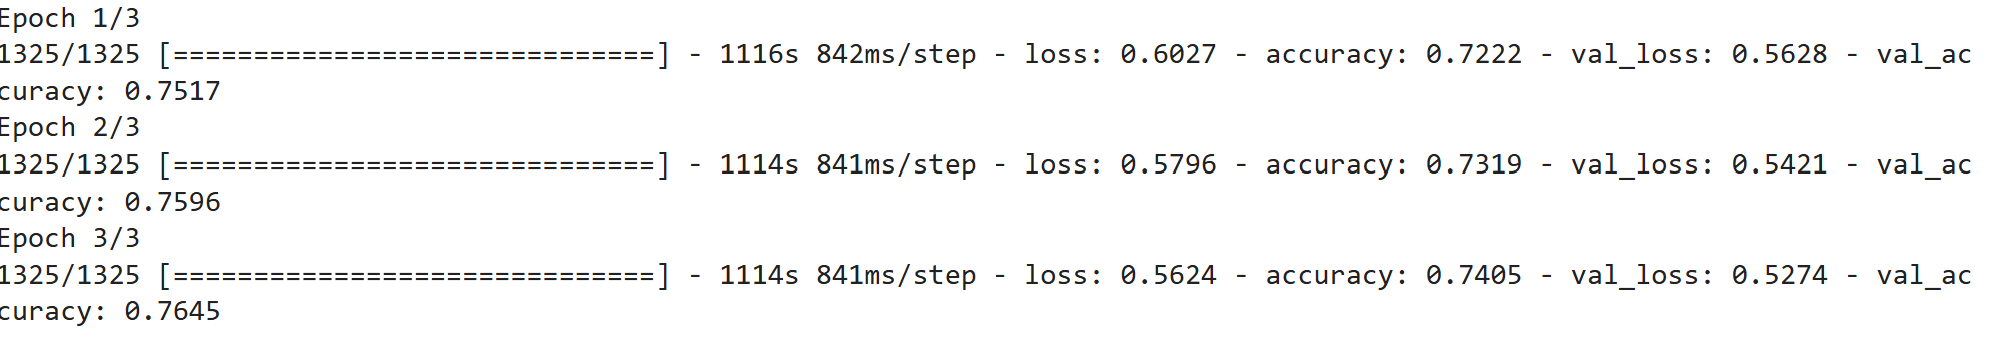

Better performance than previous models. BERT with a  Neural model with 3 NN layers gave the best performance so far. The parameters and layers can be tweaked further to get better performance of the model

# References

•	Mohd Zeeshan Ansari et al., "Analysis of Political Sentiment Orientations on Twitter," Procedia Computer Science, Volume 167, 2020.Link <br>
•	Saurabh Sahane, Twitter Sentiment Dataset, Kaggle. Link <br>
•	Mohsin Shabbir, Twitter Sentiment Analysis (Traditional and DL), Kaggle. Link<br>
•	Sentiment Analysis Of Political Tweet Data (ML and Pre-trained DL Models) | by uttam gondaliya | Medium <br>
 Jeffrey Penington, Richer Socher and Christopher D. Manning. 2014 https://nlp.stanford.edu/pubs/glove.pdf






